# Agentic RAG

It involves a series of RAG-related steps in which decisions need to be made, with the help of an LLM. In this case, we want to decide whether to retrieve context from a vector store or respond to the user directly.

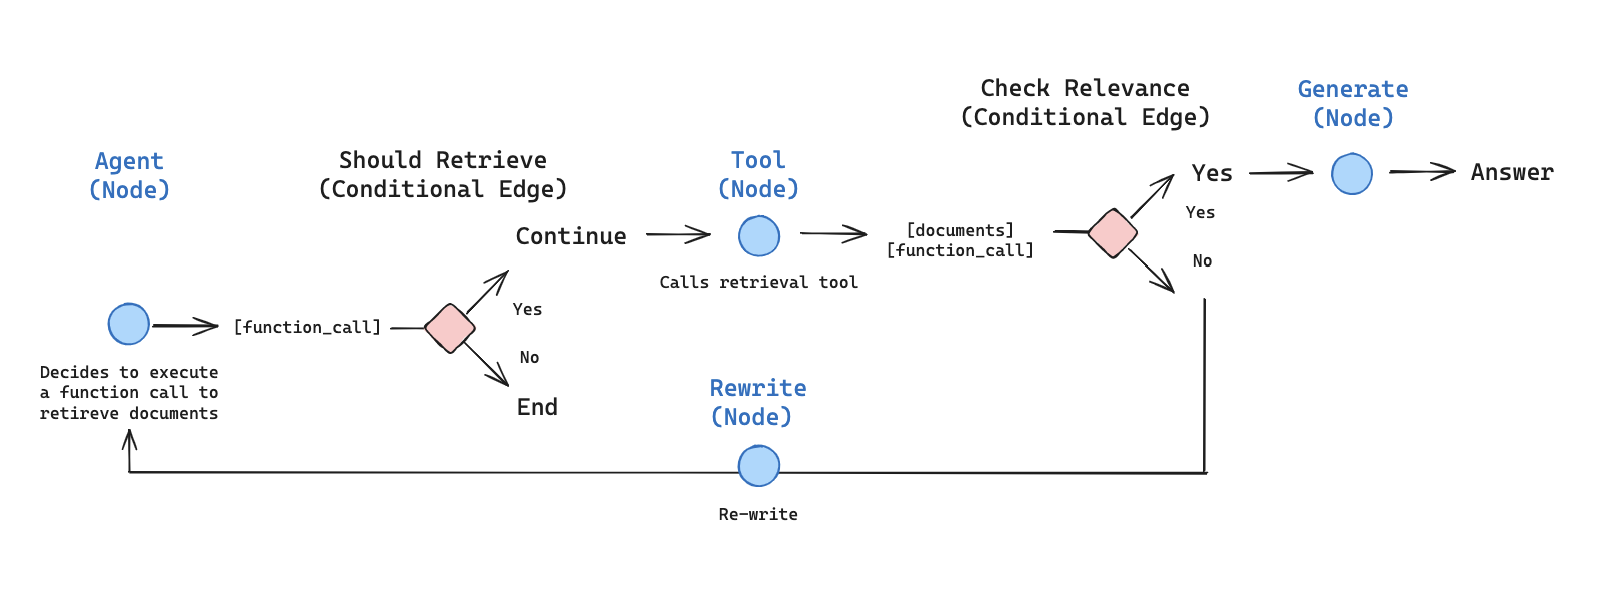

---

In [27]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import json
from dotenv import load_dotenv
import os 
from IPython.display import Image, display, Markdown
import pprint

Import the necessary classes from **Langchain** and **Langgraph**

In [ ]:
# ✅ Imports actualizados para LangChain 1.0+
from langchain_community.document_loaders import PyPDFLoader  # ✅ Actualizado
from langchain_text_splitters import RecursiveCharacterTextSplitter  # ✅ Actualizado
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings  # ✅ Cambiado de OpenAI a HuggingFace
from langchain_core.tools import create_retriever_tool  # ✅ Corregido import path
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq  # ✅ Cambiado de OpenAI a Groq
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.messages import convert_to_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import BaseMessage, HumanMessage
import os

In [ ]:
# ✅ Dependencias ya instaladas en .venv
# %pip install pypdf langgraph langchain-huggingface langchain-groq

In [29]:
# Load environment variables from .env file
load_dotenv()

True

## Ingest the document(s) and convert to chunks

In [30]:
# We consider a large PDF file
pdf_path = "./data/Understanding_Climate_Change.pdf"

loader = PyPDFLoader(pdf_path)
pdf_documents = loader.load() # Each document corresponds actually to a page
print(len(pdf_documents), "loaded")

33 loaded


In [31]:
def replace_t_with_space(list_of_documents):
    for doc in list_of_documents:
        doc.page_content = doc.page_content.replace('\t', ' ')  # Replace tabs with spaces
    return list_of_documents


# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100)

texts = text_splitter.split_documents(pdf_documents)
doc_splits = replace_t_with_space(texts)
print(len(doc_splits), "chunks")

97 chunks


For simplicity, let's use an in-memory vector store with a retriever

In [ ]:
# ✅ Usar embeddings locales gratuitos (HuggingFace)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

The retriever is adapted as a tool for the workflow

In [33]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_doc_info",
    "Search and return information about climate change.",
)

In [34]:
query = "what are the main reasons for climate change?"
result = retriever_tool.invoke({"query": query})
pprint.pprint(result)


('change the amount of solar energy our planet receives. During the Holocene '
 'epoch, which \n'
 'began at the end of the last ice age, human societies flourished, but the '
 'industrial era has seen \n'
 'unprecedented changes. \n'
 'Modern Observations \n'
 'Modern scientific observations indicate a rapid increase in global '
 'temperatures, sea levels, \n'
 'and extreme weather events. The Intergovernmental Panel on Climate Change '
 '(IPCC) has \n'
 'documented these changes extensively. Ice core samples, tree rings, and '
 'ocean sediments \n'
 'provide a historical record that scientists use to understand past climate '
 'conditions and \n'
 'predict future trends. The evidence overwhelmingly shows that recent changes '
 'are primarily \n'
 'driven by human activities, particularly the emission of greenhouse gases. \n'
 'Chapter 2: Causes of Climate Change \n'
 'Greenhouse Gases \n'
 'The primary cause of recent climate change is the increase in greenhouse '
 'gases in the \n'


## 1. Query Generation

All the nodes will work on a **MessageState**, which contains a key and a list of chat messages

In [ ]:
# ✅ Usar Groq con Llama (gratis)
llm_model = os.getenv("OPENAI_MODEL")  # llama-3.1-8b-instant
print(f"Using model: {llm_model}")

response_model = ChatGroq(model=llm_model, temperature=0)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

Testing the generation (node) with different inputs

In [37]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [38]:
input = {
    "messages": [
        {
            "role": "user",
            "content": query,
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_doc_info (call_dN2T4CDXEG3JPIhx9fYTurc7)
 Call ID: call_dN2T4CDXEG3JPIhx9fYTurc7
  Args:
    query: main reasons for climate change


## 2. Document Grading

This is s a conditional edge (in the graph) to determine whether the retrieved documents are relevant to the question.

We use a Pydantic model to record the result of the LLM decision.

In [ ]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

# ✅ Usar el mismo modelo Groq
grader_model = ChatGroq(model=llm_model, temperature=0)

In [14]:
def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

Testing the grading with different inputs

In [40]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": query,
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_doc_info",
                        "args": {"query": "types of climate adverse effects"},
                    }
                ],
            },
            {"role": "tool", "content": "hacking news", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [41]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": query,
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_doc_info",
                        "args": {"query": "is climate change a threat to humanity?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "one of the reasons for climate change is deforestation",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 3. Question Rewriting

Since the retrieval node can return irrelevant documents, one way of improving the retrieval is to re-write the original question

In [42]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

In [43]:
def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

Testing the node with different inputs

In [44]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": query,
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_doc_info",
                        "args": {"query": "is climate change a threat to humanity?"},
                    }
                ],
            },
            {"role": "tool", "content": "deforestation", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the primary factors contributing to climate change?


## 4. Answer Generation

Finally, we ask the LLM to generate a response as a normal RAG procedure.

In [20]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [21]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": query,
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_doc_info",
                        "args": {"query": "is climate change a threat to humanity?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "primary factors contributing to climate change include deforestation, and others such as ...",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The main reasons for climate change include deforestation, greenhouse gas emissions from fossil fuel combustion, and industrial activities. Additionally, agricultural practices and land use changes also play significant roles. These factors collectively increase atmospheric concentrations of greenhouse gases, leading to global warming.


## Assembling the Graph (workflow)

In [45]:
workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

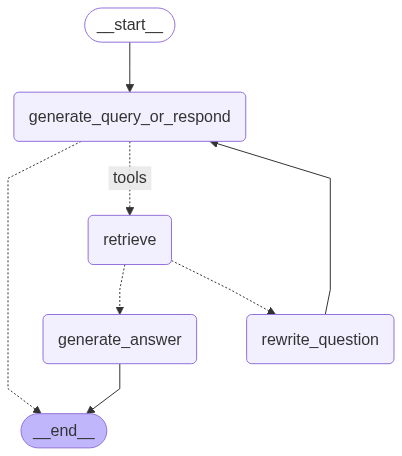

In [46]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": query,
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_doc_info (call_r36gMbl6d8BBs1Kods3DfwCm)
 Call ID: call_r36gMbl6d8BBs1Kods3DfwCm
  Args:
    query: main reasons for climate change



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_doc_info

Climate change is linked to an increase in the frequency and severity of extreme weather 
events, such as hurricanes, heatwaves, droughts, and heavy rainfall. These events can have 
devastating impacts on communities, economies, and ecosystems. 
Hurricanes and Typhoons 
Warmer ocean temperatures can intensify hurricanes and typhoons, leading to more 
destructive storms. Coastal regions are at heightened risk of storm surge and flooding. Early 
warning systems and resilient infrastructure are critical for mitigating these risks. 
Droughts 
Increased temperatures and changing preci

In [48]:
inputs = [HumanMessage(content=query)]
result = graph.invoke({"messages": inputs})
display(Markdown(result['messages'][-1].content))

The main reasons for climate change include the increase in greenhouse gases, such as carbon dioxide and methane, primarily due to human activities like burning fossil fuels and deforestation. Additionally, agriculture contributes to climate change through methane emissions from livestock and rice paddies. These factors lead to significant, long-term changes in global weather patterns and extreme weather events.

In [26]:
result

{'messages': [HumanMessage(content='what are the main reasons for climate change?', additional_kwargs={}, response_metadata={}, id='d2be4aa6-54fd-4294-b2d2-6ffd76fc6527'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kQZwACZot0QewUm2wngtbOZo', 'function': {'arguments': '{"query":"main reasons for climate change"}', 'name': 'retrieve_doc_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 64, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C9HWDkoN2Q2y5HmxZ1vw38RrcLhmv', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c396972d-895a-468d-ba12-12482405318d-0', tool_calls=[{'name': 'retr

---

## Follow-up

Can we add additional steps to the RAG workflow?
* Check if the generation has hallucinations
* Use Web search as an additional source of information

Adaptive RAG: https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/

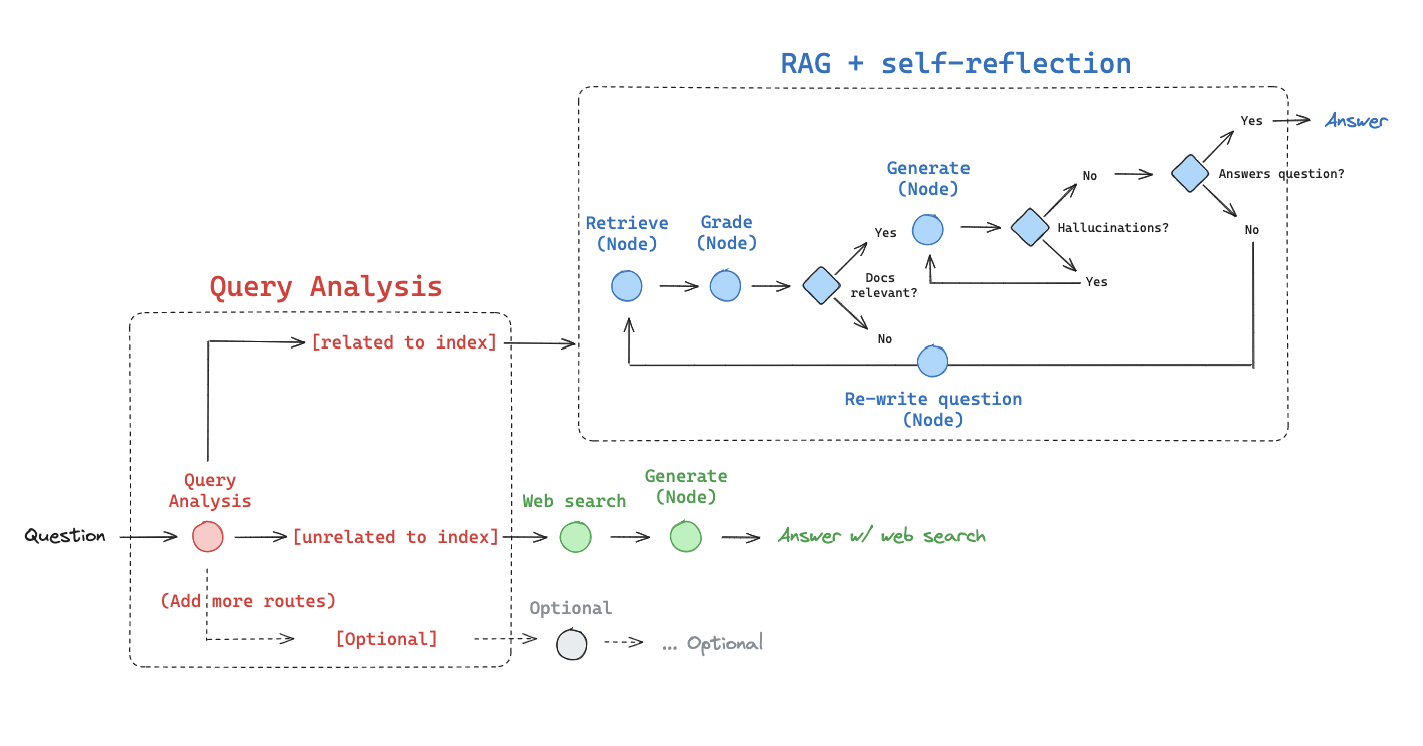